## Coupling LLM-HSM with FIRETEC/QuickFire
Elchin Jafarov 
9/2020

In [1]:
import numpy as np
#import hsiscore_class as HSI
import hsiscore_class as HSI
import LLM_model_class as llm
#import LLM_model_cpy as llm
import hsi_plot_utils as hsi_plt
import matplotlib.pyplot as plt
import time
import pandas as pd
import random
import LLM_FT_utils as llmft
%matplotlib inline
hsi=HSI.hsi_score()

### 1. Running LLM model from scratch 

Also, to produce similar runs, we can freeze/turnoff the random number generation. The toggle 'randfromfile=0 or 1' will change betwen random and determinitstic modes. Note: that high dimensions (p.dim=80) will take some time to finish. 

In [2]:
# --spinup run ---
p = llm.LLM()     # assign p to the llm class
#NOTE: p.instantiate(1) assumes that runs correspoding input files do exist if not then run
p.dim = 80
p.instantiate(0)  # 1: reads input data from file, 0: generate inputs internally
p.readfireprobfromfile=0
p.readmastprobfromfile=0
p.verbose=0

start_time = time.time()
p.run(10) # here 200 is a number of years
print("--- %s seconds ---" % (time.time() - start_time))
p.save_pickle() #saves the results

no. of starting LLP trees 1246
no. of starting HW trees 649
--- 242.22878313064575 seconds ---


Once the spin-up is over we run the tansient run 

In [2]:
# --transient run ---
#del p
p = llm.LLM() 
p.dim = 80
p.randfromfile=0
p.instantiate(1)  # 1: reads input data from file, 0: generate inputs internally
p.verbose=0       # 0: do not print out scores, 1: print scores on the screen
p.tree_mature_age=10
p.readfireprobfromfile=0
p.readmastprobfromfile=0

start_time = time.time()
p.run(1)
print("--- %s seconds ---" % (time.time() - start_time))
if np.sum(p.litter)==0:
    print('no litter, making extra run...')
    p.fire_prob=0
    p.run(1)

#p.save_randfromfile()

no. of starting LLP trees 1310
no. of starting HW trees 626
no. of starting LLP trees read from file: 31293.0
no. of starting HW trees read from file: 2121.0
Data read from files!
--- 11.245130062103271 seconds ---
no litter, making extra run...


### 2. LLM to FireTec
First, we calculate the dbh and crown radius for LLPs and HWs.

/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:88: RuntimeWarning: divide by zero encountered in log
  y = a1+a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWarning: divide by zero encountered in log
  y = np.log(dbh)-a1-a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWarning: invalid value encountered in subtract
  y = np.log(dbh)-a1-a2*np.log(H-1.37)


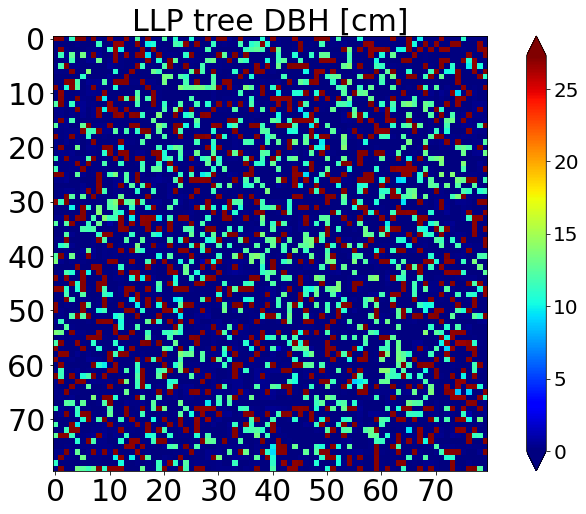

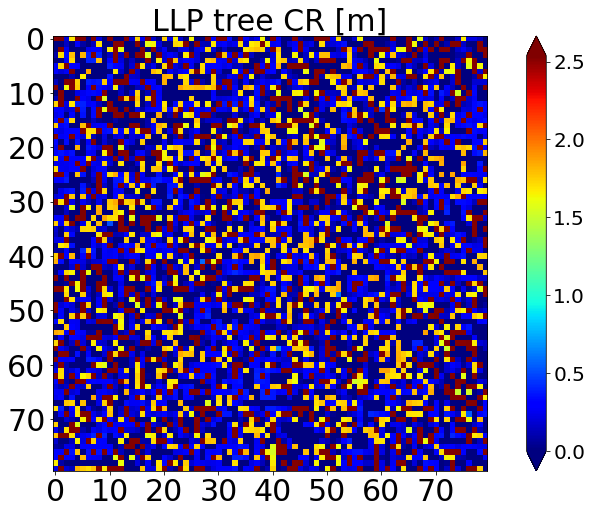

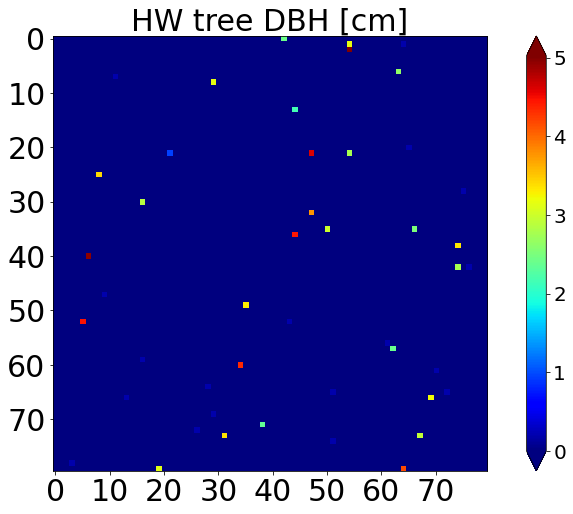

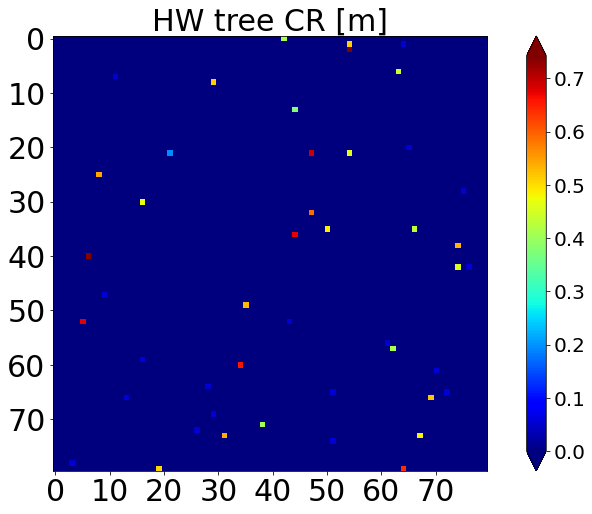

In [3]:
lp_count=p.old_LPcount.copy()
lp_count[p.old_ht<1.37]=0

lp_height=p.old_ht.copy()
lp_height[lp_height<1.37]=1.37
p.lp_dbh=llmft.dbh1_model(lp_height)
#print dbh
axx=llmft.plot_area_matrix(p.lp_dbh,'LLP tree DBH [cm]','yes')

lp_CA=llmft.dbh2_model(lp_height,p.lp_dbh)
p.lp_CR=np.sqrt(lp_CA/np.pi) #LLP Crown Area
all_NaNs = np.isnan(p.lp_CR)
p.lp_CR[all_NaNs] = 0
axx=llmft.plot_area_matrix(p.lp_CR,'LLP tree CR [m]','yes')

hw_height=p.old_htHW.copy()
hw_height[hw_height<1.37]=1.37
p.hw_dbh=llmft.dbh1_model(hw_height)
#print dbh
axx=llmft.plot_area_matrix(p.hw_dbh,'HW tree DBH [cm]','yes')

hw_CR=llmft.dbh2cr_hw(p.hw_dbh/2.54) # note dbh is in inch
p.hw_CR=hw_CR/3.281            # CR is in feet convert to meters
all_NaNs = np.isnan(p.hw_CR)
p.hw_CR[all_NaNs] = 0
axx=llmft.plot_area_matrix(p.hw_CR,'HW tree CR [m]','yes') 

In [30]:
!python DRM_framework_coupling.py 10 'LLM2FT'

Run time [years]: 10
Folder name: LLM2FT
--------------------------
no. of starting LLP trees 1291
no. of starting HW trees 612
Running LLM spinup for 10  years....
--- spinup 213.41839408874512 seconds ---
no. of starting LLP trees 1303
no. of starting HW trees 608
no. of starting LLP trees read from file: 26849.0
no. of starting HW trees read from file: 2231.0
Data read from files!
Running LLM transient for 10  years....
--- transient 315.59079599380493 seconds ---
no litter, making an extra run...
End of spinup and transient runs
--------------------------

/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:88: RuntimeWarning: divide by zero encountered in log
  y = a1+a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWarning: divide by zero encountered in log
  y = np.log(dbh)-a1-a2*np.log(H-1.37)
/Users/elchin/Documents/Adams_project/llm-hsm-ft/1.LLM-HSM-MODEL/LLM_FT_utils.py:100: RuntimeWar

#### 2.1 Regrid LLM litters (80x80), each cell area 25m2  and save them in FT format (200x200), 4m2 cell area

In [7]:
#filename='First_Fire_Runs/HI-P-ET-FIRE1-LLM2FT/LLM_litter_WG.dat'
#filename='First_Fire_Runs/LOW-P-ET-FIRE1-LLM2FT/LLM_litter_WG.dat'
filename='LLM2FT/dummy_litter_WG.dat'
ftitle='WG litter [kg/4m2]'
llmft.save_litter_LLM_FT(filename,ftitle,p.litterWG,'noplot')

#filename='First_Fire_Runs/HI-P-ET-FIRE1-LLM2FT/LLM_litter_tree.dat'
#filename='First_Fire_Runs/LOW-P-ET-FIRE1-LLM2FT/LLM_litter_tree.dat'
filename='LLM2FT/dummy_litter_tree.dat'
ftitle='LLP + HW litter [kg/4m2]'
tree_litter=p.litterHW+p.litter
llmft.save_litter_LLM_FT(filename,ftitle,tree_litter,'noplot')

percent_LP_litter=np.sum(p.litter)/np.sum(p.litterHW+p.litter)
percent_HW_litter=np.sum(p.litterHW)/np.sum(p.litterHW+p.litter)
print ('lit_LLP%, lit_HW%:',percent_LP_litter,percent_HW_litter)
#print ('lit_LLP%, lit_HW%')
#print (np.sum(p.litter)/np.sum(p.litterHW+p.litter), np.sum(p.litterHW)/np.sum(p.litterHW+p.litter))

shape of the litter matrix: 80 80
sum of the old litter matrix: 10775.812426351897
sum of the old litter matrix: 67397.42346569229
litter file: LLM2FT/dummy_litter_WG.dat  saved!
shape of the litter matrix: 80 80
sum of the old litter matrix: 20109.007618112206
sum of the old litter matrix: 125479.48790689919
litter file: LLM2FT/dummy_litter_tree.dat  saved!
lit_LLP%, lit_HW%: 0.9996003407610402 0.000399659238959883


#### 2.2 Make treelist file for the first run 

(2186, 6)
(42, 6)


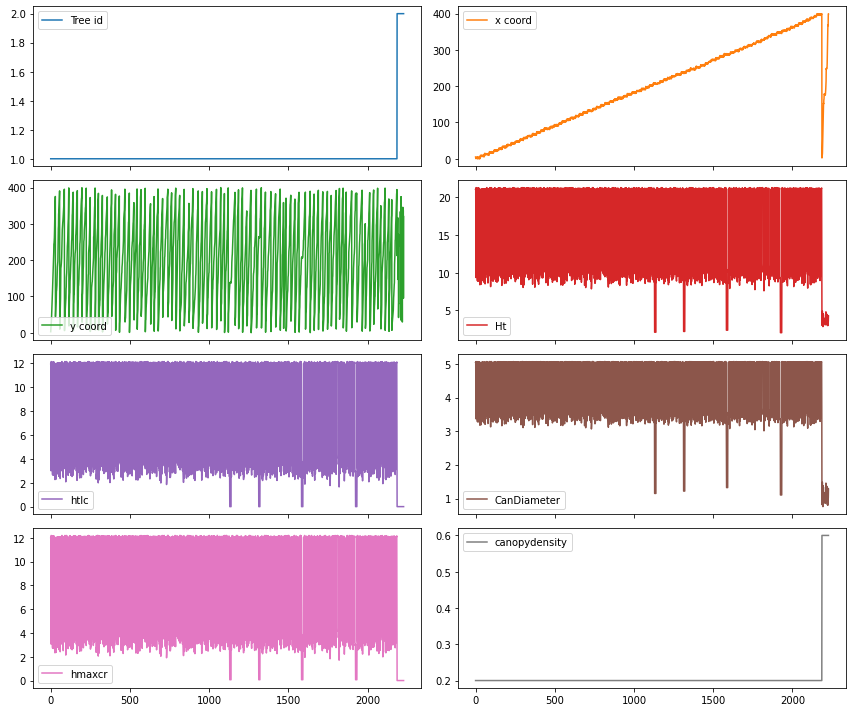

In [5]:
llmft.create_treelist(p,'LLM2FT/treelist_LLM.dat')
#check the created treelist file
df = pd.read_csv('LLM2FT/treelist_LLM.dat',sep=' ',
                    names=["Tree id","x coord","y coord","Ht",
                        "htlc","CanDiameter","hmaxcr","canopydensity"]) 
df.plot(subplots=True, layout=(4,2),figsize=(12, 10));
plt.tight_layout()

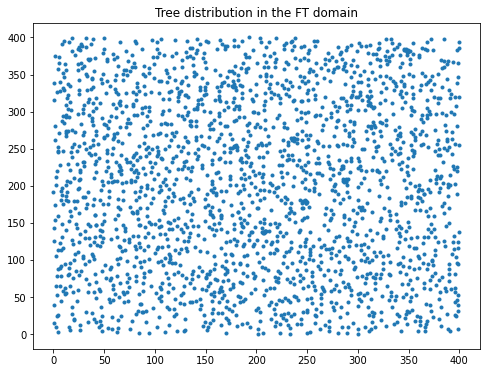

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(df["x coord"].values,df["y coord"].values,'.')
plt.title('Tree distribution in the FT domain');

Once we have all three files ..._litter_tree.dat, ..._litter_WG.dat and treelist_LLM.dat we can pass them to the Tree code which would calculate FT input files.

### 3. FireTec to LLM (cyclical)  
After the FT finishes its run, we convert back to the LLM-HSM format and run the LLM-HSM model with no fire. Then convert litters back to FT. Here we need to re-calculate treelist, since after LLM-HSM number of trees per cell could change.

FT tree litter size : 200 200
FT tree litter sum (2m2 res): 109814.87999999999
LLM tree litter sum (5m2 res): 18356.398481012686
FT WG litter size : 200 200
FT WG litter sum (2m2 res): 23531.760000000002
LLM WG litter sum (5m2 res): 3936.688101265829
number FT of trees in treelist:  4450
total LLM tree count:  4450.0
number FT of trees in treelist:  967
total LLM tree count:  967.0
--- 967.6410791873932 seconds ---
80 80
4695.346833432717
28067.309073612316
(200, 200)
80 80
62889.192128670664
387377.2140883894
(200, 200)
lit_LLP%, lit_HW%
0.9969722302605478 0.003027769739452387


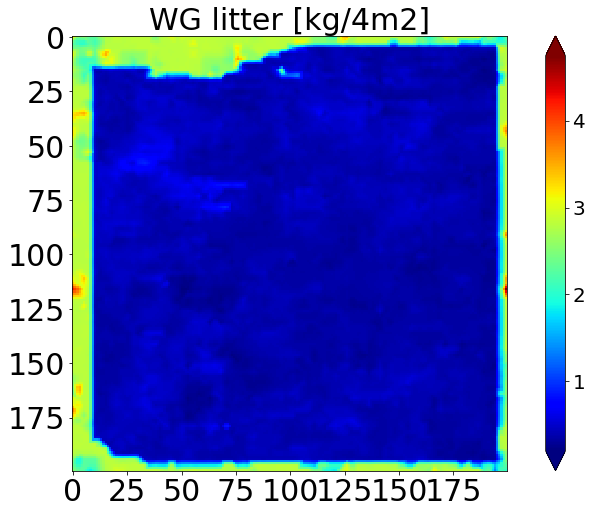

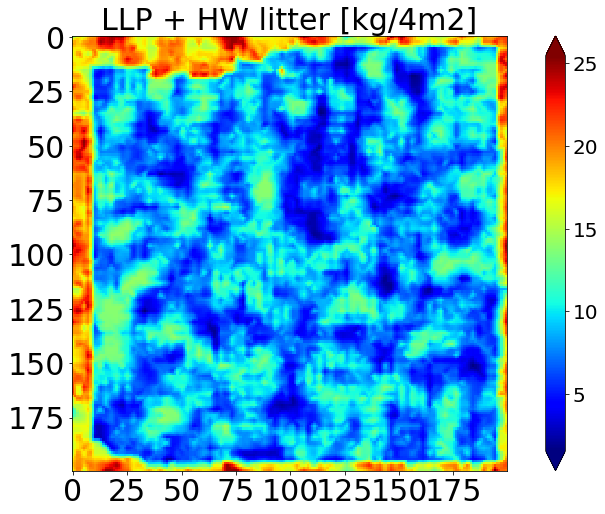

In [11]:
flitter='FT2LLM/AfterFireLitter.txt'
fwg='FT2LLM/AfterFireWG.txt'
ftlist='FT2LLM/AfterFireTrees.txt'
p=llmft.read_FT_2_LLM(flitter,fwg,ftlist,p)

#run the LLM-HSI for 5 years
p.fire_prob=0
start_time = time.time()
p.run(5)
print("--- %s seconds ---" % (time.time() - start_time))

#save new FT littes files
filename='FT2LLM/LLM_litter_WG.dat'
ftitle='WG litter [kg/4m2]'
llmft.save_litter_LLM_FT(filename,ftitle,p.litterWG)

filename='FT2LLM/LLM_litter_tree.dat'
ftitle='LLP + HW litter [kg/4m2]'
tree_litter=p.litterHW+p.litter
llmft.save_litter_LLM_FT(filename,ftitle,tree_litter)

LLPlit_per=np.sum(p.litter)/np.sum(p.litterHW+p.litter)
HWlit_per=np.sum(p.litterHW)/np.sum(p.litterHW+p.litter)

print ('lit_LLP%, lit_HW%')
print (LLPlit_per,HWlit_per) 

/Users/l316071/Documents/hvi-score-10/LLM-HSM-FT-coupling/LLM_FT_utils.py:88: RuntimeWarning: divide by zero encountered in log
  y = a1+a2*np.log(H-1.37)
/Users/l316071/Documents/hvi-score-10/LLM-HSM-FT-coupling/LLM_FT_utils.py:100: RuntimeWarning: divide by zero encountered in log
  y = np.log(dbh)-a1-a2*np.log(H-1.37)
/Users/l316071/Documents/hvi-score-10/LLM-HSM-FT-coupling/LLM_FT_utils.py:100: RuntimeWarning: invalid value encountered in subtract
  y = np.log(dbh)-a1-a2*np.log(H-1.37)


number of LLPs: 3376.0
number of HWs: 442.0
tt_llp: (4450, 6)
lplist: (4548, 6)
tt_hw: (967, 6)
hwlist: (1006, 6)
lp_newlist (3133, 6)
hw_newlist (211, 6)
(3344, 8)


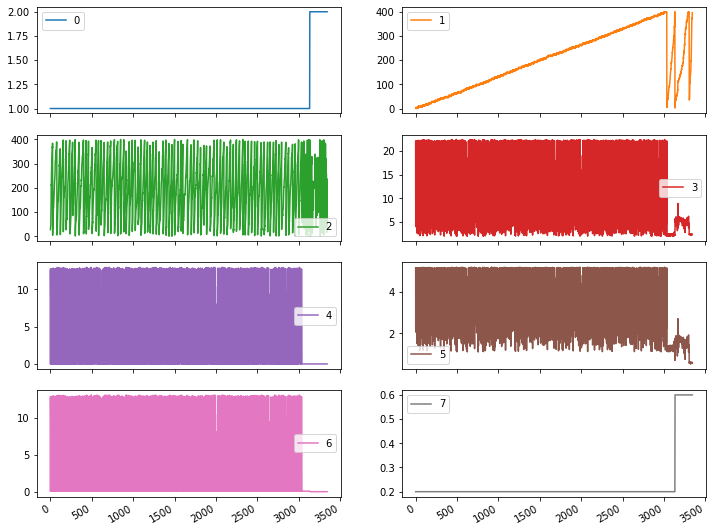

In [12]:
ftlist='FT2LLM/AfterFireTrees.txt'
[lp_list,hw_list]=llmft.update_tree_info_per_location(p,ftlist,0)

df_hw = pd.DataFrame(hw_list)
df = pd.DataFrame(lp_list)
df=df.append(df_hw)
#df.plot(subplots=True, layout=(4,2),figsize=(12, 10));
df.to_csv('treelist_LLM.dat', sep=' ',header=False,index=False)

file_in='treelist_LLM.dat'
file_out='FT2LLM/treelist_LLM.dat'
llmft.save_FT_treelist(file_in,file_out,1)

Now repreat step 3 every time when FT finishes it run 